# Bank marketing classification

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). For details see .txt file

## Data importation

Importing dataset and creating train and test sets

In [126]:
# libraries importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn

from sklearn.preprocessing import StandardScaler, Imputer, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, learning_curve, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline

In [69]:
#importing dataset
df = pd.read_csv('bank-additional-full.csv', header = 0, sep = ';')
df['y'].replace(['yes', 'no'], [1, 0], inplace = True)
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [24]:
#positive class proportion
print(sum(df['y']) / len(df))

0.112654171118


In [93]:
# creating train and test sets
train, test = train_test_split(df.values, test_size = 0.25, stratify = df['y'].values, random_state = 147)
df_train = pd.DataFrame(train, columns = df.columns)
df_test = pd.DataFrame(test, columns = df.columns)
y_train = df_train['y'].values.astype(int)
y_test = df_test['y'].values.astype(int)
df_train.drop(['y', 'duration'], axis = 1, inplace = True)
df_test.drop(['y', 'duration'], axis = 1, inplace = True)
print(df_train.shape, df_test.shape, len(y_train), len(y_test), sum(y_train)/len(y_train), sum(y_test)/len(y_test))

(30891, 19) (10297, 19) 30891 10297 0.112654171118 0.112654171118


So we have 41188 observations and 21 features, but one of them (y) is our variable of interest, and another one (duration) has to be excluded to build a realistic predictive model. We'll use 75% of data (30891 observations) to build a model, and 25% (10297 observations) to test it. Also we see that classes are unbalanced, only 11.3% of observations belong to positive class

## Exploratory data analysis

Data description, calculating correlation of numeric feautres and data visualization

In [129]:
#creating categorical and numerical dataframes
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                'contact', 'month', 'day_of_week', 'poutcome']
df_train_cat = df_train[cat_features]
df_train_num = df_train.drop(cat_features, axis = 1).astype('float64')
df_test_cat = df_test[cat_features]
df_test_num = df_test.drop(cat_features, axis = 1).astype('float64')
print(df_train_cat.shape, df_train_num.shape, df_test_cat.shape, df_test_num.shape)

(30891, 10) (30891, 9) (10297, 10) (10297, 9)


In [77]:
df_train_num.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,30891.000000,30891.000000,30891.000000,30891.000000,30891.000000,30891.000000,30891.000000,30891.000000,30891.000000
mean,40.004241,2.583503,962.937555,0.171992,0.087624,93.579397,-40.513166,3.625851,5167.153174
std,10.400669,2.842956,185.759623,0.493637,1.567111,0.578908,4.614551,1.732677,72.222853
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.798000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [72]:
df_train_cat.describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,30891,30891,30891,30891,30891,30891,30891,30891,30891,30891
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,7843,18707,9178,24413,16175,25464,19579,10372,6494,26691


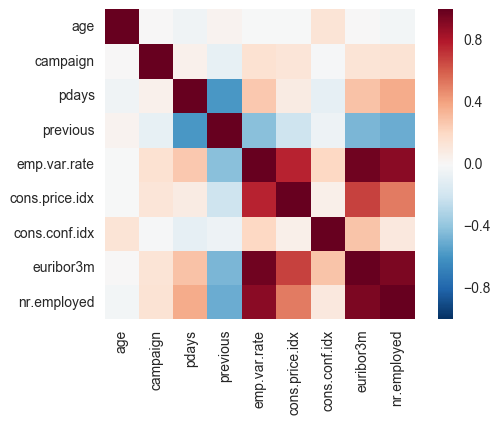

In [78]:
#correlation of numerical features
seaborn.heatmap(df_train_num.corr(), square = True)

In [79]:
df_train_num.corr()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,0.005499,-0.040857,0.032469,-0.004835,-0.000950,0.134750,0.005485,-0.025508
campaign,0.005499,1.000000,0.053675,-0.080164,0.151630,0.126605,-0.011644,0.136533,0.145285
pdays,-0.040857,0.053675,1.000000,-0.582990,0.269754,0.078297,-0.090965,0.295743,0.372074
previous,0.032469,-0.080164,-0.582990,1.000000,-0.420687,-0.205351,-0.052946,-0.454370,-0.499706
emp.var.rate,-0.004835,0.151630,0.269754,-0.420687,1.000000,0.773307,0.203186,0.972148,0.905612
cons.price.idx,-0.000950,0.126605,0.078297,-0.205351,0.773307,1.000000,0.062383,0.685201,0.516548
cons.conf.idx,0.134750,-0.011644,-0.090965,-0.052946,0.203186,0.062383,1.000000,0.284419,0.108258
euribor3m,0.005485,0.136533,0.295743,-0.454370,0.972148,0.685201,0.284419,1.000000,0.944644
nr.employed,-0.025508,0.145285,0.372074,-0.499706,0.905612,0.516548,0.108258,0.944644,1.000000


In [81]:
#correlation with y
scaler = StandardScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num.values), columns = df_train_num.columns)
df_train_num_scaled['y'] = y_train
df_train_num_scaled_1 = df_train_num_scaled[df_train_num_scaled['y'] == 1]
df_train_num_scaled_0 = df_train_num_scaled[df_train_num_scaled['y'] == 0]
correlations = pd.DataFrame(df_train_num_scaled_1.iloc[:,:-1].mean() - df_train_num_scaled_0.iloc[:,:-1].mean(),
                           columns = ['correlation']).sort_values(by = 'correlation')
correlations

,correlation
nr.employed,-1.109949
pdays,-1.036398
euribor3m,-0.963100
emp.var.rate,-0.931378
cons.price.idx,-0.420985
campaign,-0.207043
age,0.108955
cons.conf.idx,0.166479
previous,0.714729


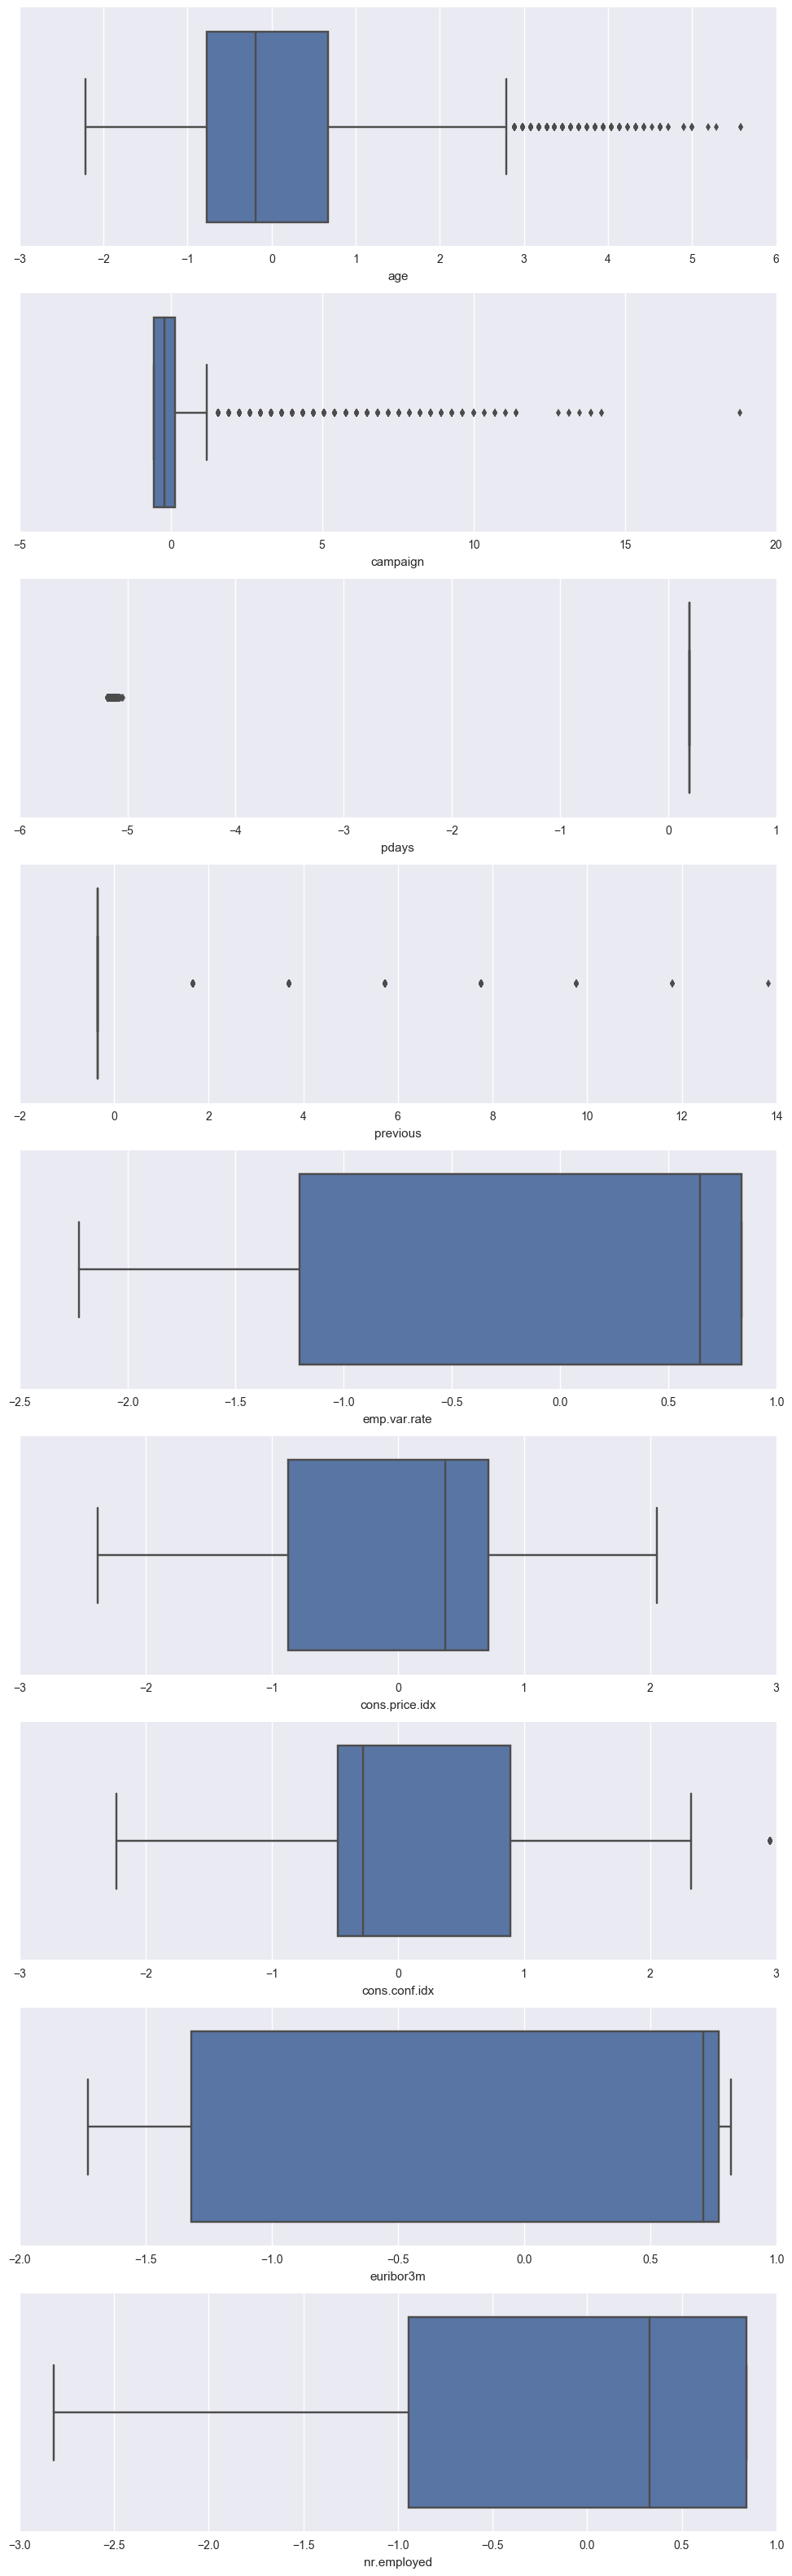

In [85]:
#boxplots
plt.figure(figsize = (12, 40))
for i, feature in enumerate(df_train_num.columns):
    plt.subplot(len(df_train_num.columns), 1, (i+1))
    seaborn.boxplot(x = feature, data = df_train_num_scaled, hue = 'y')

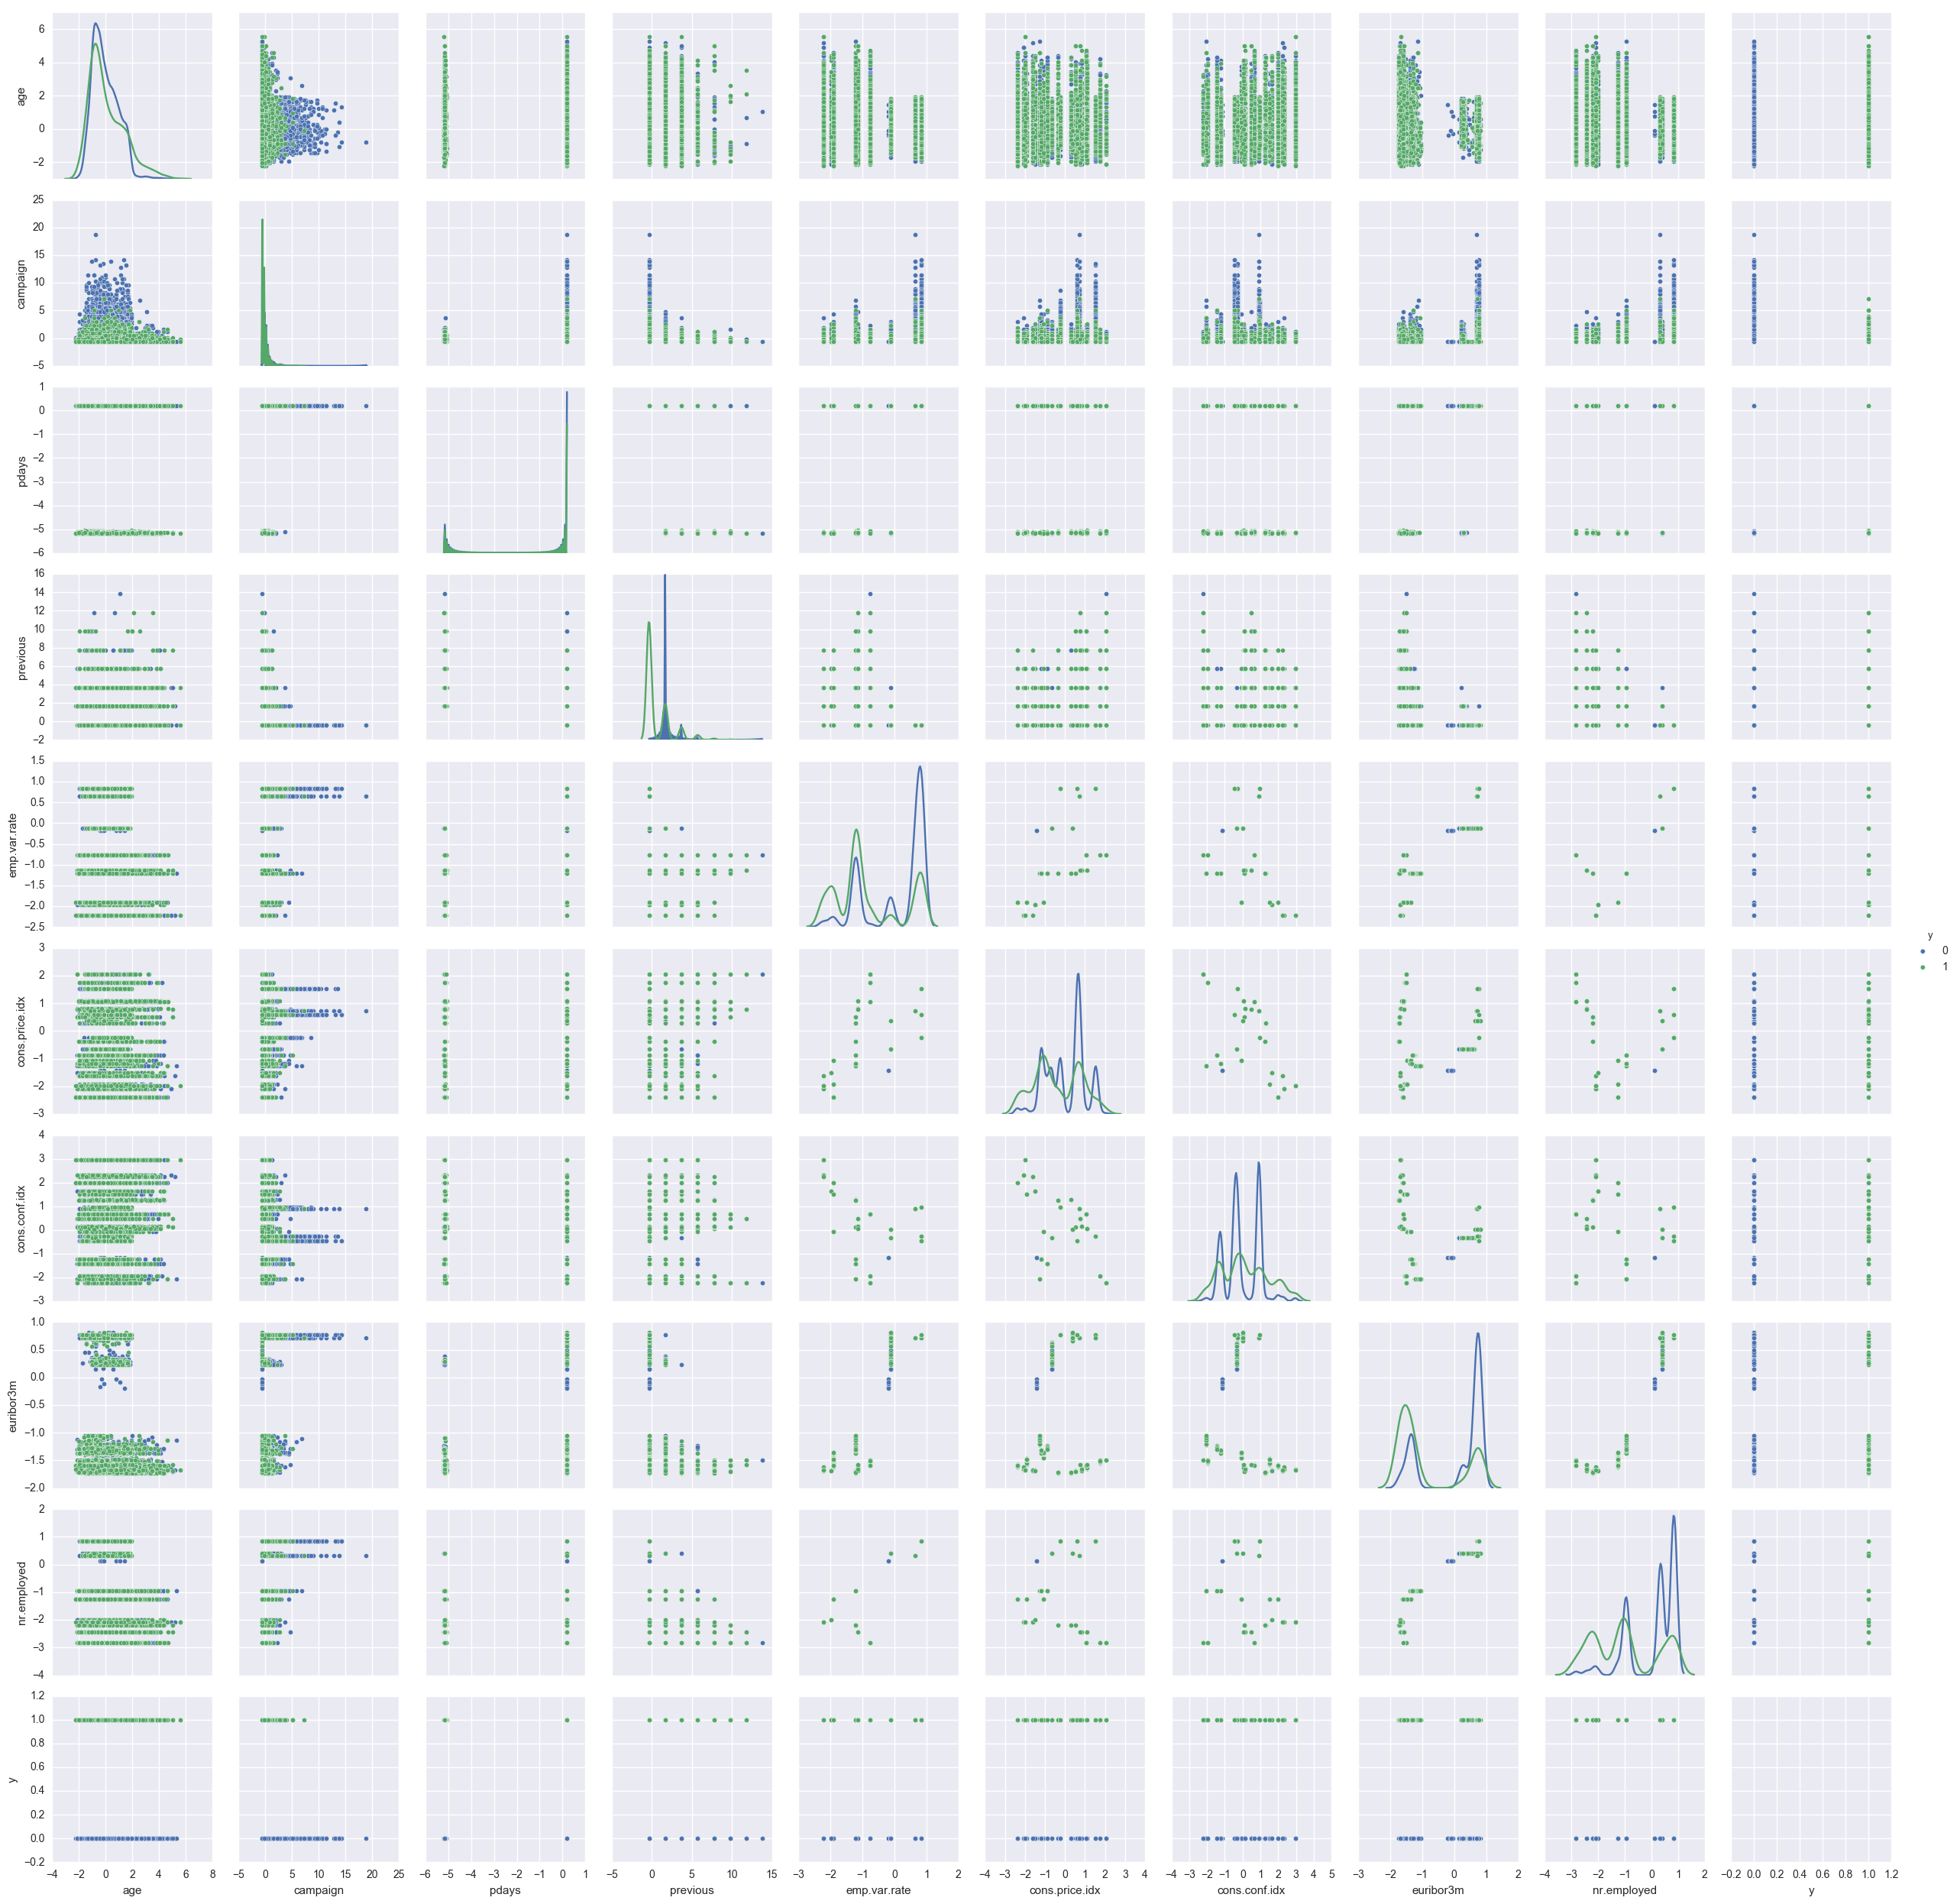

In [39]:
seaborn.pairplot(df_train_num_scaled, hue = 'y', diag_kind = 'kde')

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


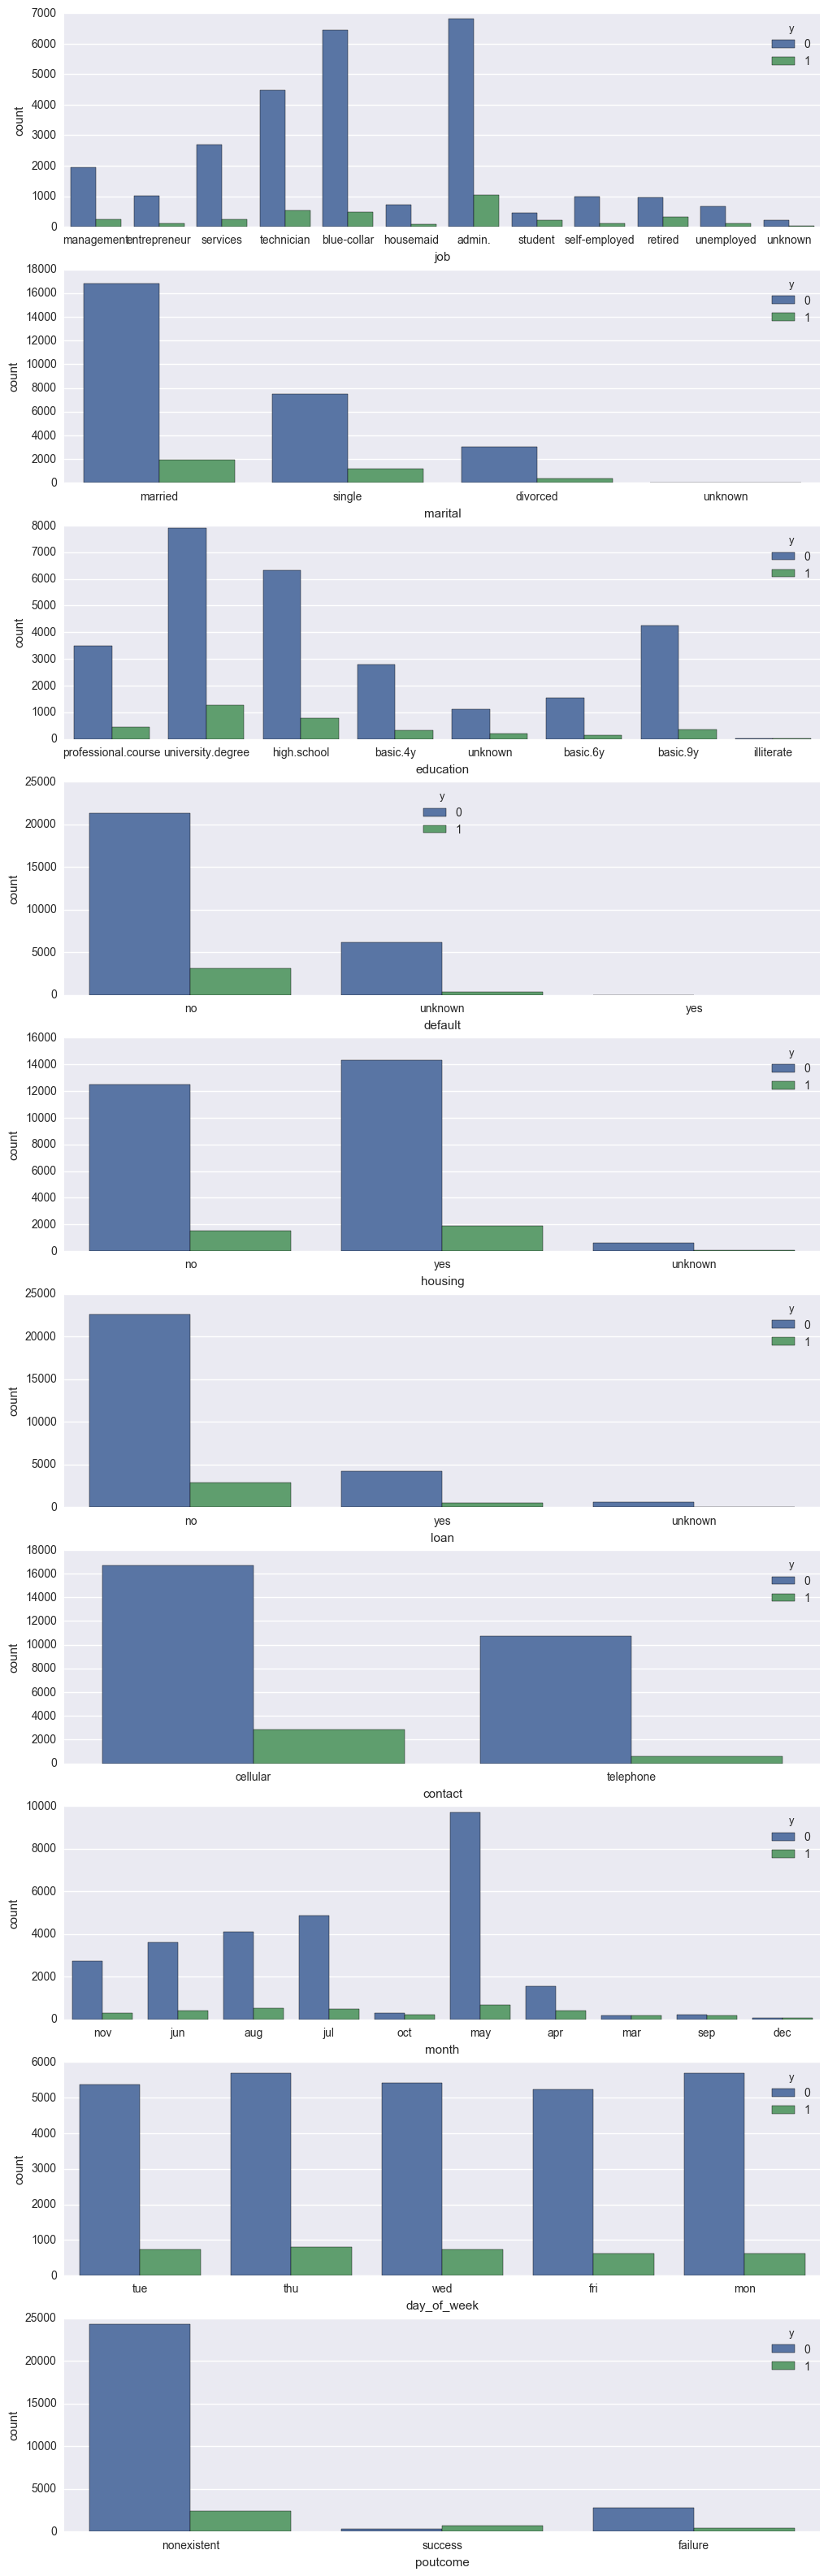

In [73]:
#count number of 0 and 1 for every category for categorical features
plt.figure(figsize = (12, 40))
df_train_cat['y'] = y_train
for i, feature in enumerate(cat_features):
    plt.subplot(len(cat_features), 1, (i+1))
    seaborn.countplot(x = feature, data = df_train_cat, hue = 'y')

In [67]:
#2D visualization by t-SNE, we use here only numerical features and we use only 10% of train data set, because
#t-SNE is computationally expensive
df_123, df_tsne = train_test_split(df_train_num_scaled, test_size = 0.1, 
                                   stratify = df_train_num_scaled['y'].values, random_state = 147)
y_tsne = df_tsne['y'].astype('int64').values
df_tsne.drop('y', axis = 1, inplace = True)

tsne = TSNE(n_components = 2, random_state = 147, method = 'exact')
tsne_reduction = tsne.fit_transform(df_tsne)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


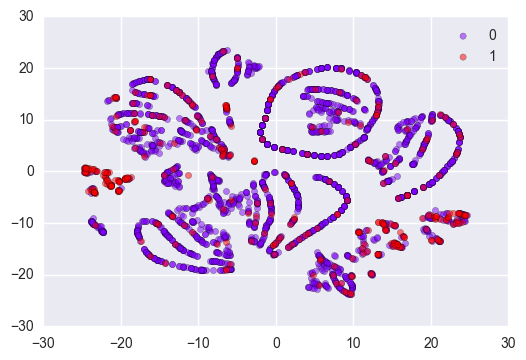

In [68]:
colors = cm.rainbow(np.linspace(0, 1, len(set(y_tsne))))
for y, c in zip(set(y_tsne), colors):
    plt.scatter(tsne_reduction[y_tsne == y, 0], tsne_reduction[y_tsne == y, 1], c = c, alpha = 0.5, label = str(y))
plt.legend()

Exploratory data analysis gives us following results:

* almost all numerical features are correlated with y, only three features(campaign, age, cons.conf.idx) have correlation between -0.25 and 0.25
* emp.var.rate, euribor3m and nr.employed are highly correlated, adding all of them may lead to overfitting, feature selection or regularization might be needed
* none of these features has normal distribution
* only for feature campaign its pairplots have visually separable classes
* several pairplots have only zero class observations
* for several categories  probability of deposit subscription is much higher
* using 2D visualization of numerical features, we see, that there are groups of class 0 and class 1 points, but their separation will be rather difficult, but here we take into account only numerical variables

## Making baseline models

We will use as baseline models logistic regression, support vector machine with linear kernel, random forest and gradient boosting

In [131]:
# creating feature matrix
le = LabelEncoder()
ohe = OneHotEncoder()
X_train_num = df_train_num_scaled.drop('y', axis = 1).values

df_train_cat.drop('y', axis = 1, inplace = True)
for feature in df_train_cat.columns:
    df_train_cat[feature] = le.fit_transform(df_train_cat[feature].values)
    df_test_cat[feature] = le.transform(df_test_cat[feature].values)
X_train_cat = ohe.fit_transform(df_train_cat.values)
X_train = np.concatenate((X_train_num, X_train_cat.toarray()), axis = 1)
print(X_train.shape)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(30891, 62)


In [94]:
#calculating ROC AUC score for every baseline model
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 147)
lr_class = LogisticRegression()
sv_class = LinearSVC()
rf_class = RandomForestClassifier(n_estimators = 100, random_state = 147)
gb_class = GradientBoostingClassifier(n_estimators = 100, random_state = 147)

lr_score = np.mean(cross_val_score(lr_class, X_train, y_train, cv = skf, scoring = 'roc_auc'))
sv_score = np.mean(cross_val_score(sv_class, X_train, y_train, cv = skf, scoring = 'roc_auc'))
rf_score = np.mean(cross_val_score(rf_class, X_train, y_train, cv = skf, scoring = 'roc_auc'))
gb_score = np.mean(cross_val_score(gb_class, X_train, y_train, cv = skf, scoring = 'roc_auc'))
print(lr_score, sv_score, rf_score, gb_score)

0.788986905874 0.785176920054 0.769508208306 0.797151023802


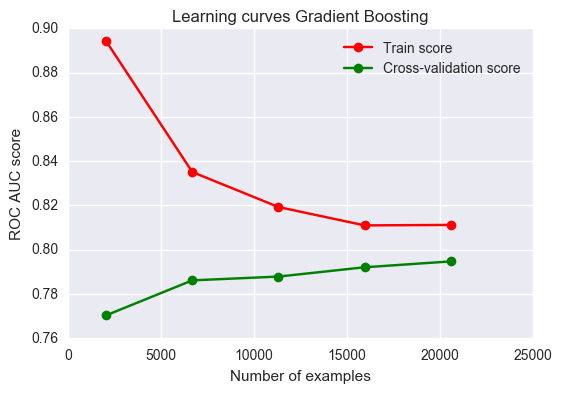

In [98]:
train_gb_size, train_score_gb, test_score_gb = learning_curve(gb_class, X_train, y_train, scoring = 'roc_auc')
train_gb_mean = np.mean(train_score_gb, axis = 1)
test_gb_mean = np.mean(test_score_gb, axis = 1)
plt.plot(train_gb_size, train_gb_mean, 'o-', color = 'r', label = 'Train score')
plt.plot(train_gb_size, test_gb_mean, 'o-', color = 'g', label = 'Cross-validation score')
plt.xlabel('Number of examples')
plt.ylabel('ROC AUC score')
plt.title('Learning curves Gradient Boosting')
plt.legend()
plt.show()

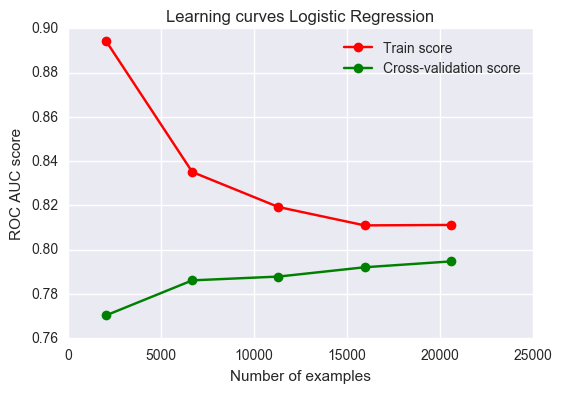

In [99]:
train_lr_size, train_score_lr, test_score_lr = learning_curve(gb_class, X_train, y_train, scoring = 'roc_auc')
train_lr_mean = np.mean(train_score_lr, axis = 1)
test_lr_mean = np.mean(test_score_lr, axis = 1)
plt.plot(train_lr_size, train_lr_mean, 'o-', color = 'r', label = 'Train score')
plt.plot(train_lr_size, test_lr_mean, 'o-', color = 'g', label = 'Cross-validation score')
plt.xlabel('Number of examples')
plt.ylabel('ROC AUC score')
plt.title('Learning curves Logistic Regression')
plt.legend()
plt.show()

As we see, the best baseline models are logistic regression and gradient boosting. We have also checked, that adding new observations increases ROC AUC score on test set, so we should use all of our data. We'll try to improve both them (because dataset is relatively small, so it isn't very computationally expensive to work with both models)

## Model improvement

### Polynomial features

In [139]:
#adding polynomial features
pf = PolynomialFeatures(degree = 2, include_bias = False)
X_train_num_sq = pf.fit_transform(df_train_num.values)
X_train_num_sq = scaler.fit_transform(X_train_num_sq)
X_train_sq = np.concatenate((X_train_num_sq, X_train_cat.toarray()), axis = 1)
print(X_train_sq.shape)

(30891, 107)


In [119]:
lr_score = np.mean(cross_val_score(lr_class, X_train_sq, y_train, cv = skf, scoring = 'roc_auc'))
gb_score = np.mean(cross_val_score(gb_class, X_train_sq, y_train, cv = skf, scoring = 'roc_auc'))
print(lr_score, gb_score)

0.791015845162 0.801245835074


We see, that adding polynomial features helps us to increase AUC ROC. Degree 3 was also tested, it leads to overfitting.

### Feature Selection

In [120]:
#feature selection using l1-regularization. For every ragularization rate, number of deleted features is printed
lasso_rate = [0.01, 0.1, 1, 10]
indexes = []
indexes_nz = []
for C in lasso_rate:
    lasso_class = LogisticRegression(penalty = 'l1', C = C)
    lasso_class.fit(X_train_sq, y_train)
    indexes.append(np.where(lasso_class.coef_ == 0)[1])
    indexes_nz.append(np.where(lasso_class.coef_ != 0)[1])
    print((lasso_class.coef_ == 0).sum())

92
55
29
16


In [121]:
#ROC AUC score for logistic regression for every feature selection by l1-regularization
lasso_lr_roc = []
for i in range(4):
    lasso_lr_roc.append(np.mean(cross_val_score(lr_class, np.delete(X_train_sq, indexes[i], axis = 1), 
                                     y_train, cv = skf, scoring = 'roc_auc')))
print(lasso_lr_roc)

[0.78485865528536924, 0.79035305646779719, 0.79114137167054466, 0.79114943952524752]


In [122]:
#ROC AUC score for gradient boosting for every feature selection by l1-regularization
lasso_gb_roc = []
for i in range(4):
    lasso_gb_roc.append(np.mean(cross_val_score(gb_class, np.delete(X_train_sq, indexes[i], axis = 1), 
                                     y_train, cv = skf, scoring = 'roc_auc')))
print(lasso_gb_roc)

[0.79277019439632845, 0.80117361710685375, 0.79835308247094938, 0.80130666691099284]


In [123]:
#Feature selection by SelectFromModel
lr_class.fit(X_train_sq, y_train)
lr_model = SelectFromModel(lr_class, prefit = True)
X_train_lr = lr_model.transform(X_train_sq)

gb_class.fit(X_train_sq, y_train)
gb_model = SelectFromModel(gb_class, prefit = True)
X_train_gb = gb_model.transform(X_train_sq)

print(np.mean(cross_val_score(lr_class, X_train_lr, y_train, cv = skf, scoring = 'roc_auc')),
      np.mean(cross_val_score(gb_class, X_train_gb, y_train, cv = skf, scoring = 'roc_auc')),
      X_train_lr.shape, X_train_gb.shape)

0.791992497345 0.801793163678 (30891, 37) (30891, 26)


So we can improve our model using only 37 features for logistic regression and 26 features for gradient boosting instead of 107. We also see, that SelectFromModel works better and allows us to use less features, than l1-regularization.

### Hyperparameters tuning

Here using GridSearchCV we will find the best models. As hyperparameters, we will use class weight and l2 regularization rate for logistic regression, and number of trees, max depth of tree and max number of features for every tree for gradient boosting.

In [124]:
grid_lr = {'class_weight': ['balanced', None], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
gs_lr = GridSearchCV(lr_class, grid_lr, cv = skf, scoring = 'roc_auc')
gs_lr.fit(X_train_lr, y_train)
print(gs_lr.best_score_, gs_lr.best_params_)

0.793579594209 {'class_weight': 'balanced', 'C': 1000}


In [125]:
grid_gb = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [2, 3, 4], 'max_features': ['sqrt', 'log2']}
gs_gb = GridSearchCV(gb_class, grid_gb, cv = skf, scoring = 'roc_auc')
gs_gb.fit(X_train_gb, y_train)
print(gs_gb.best_score_, gs_gb.best_params_)

0.803899386772 {'max_features': 'sqrt', 'n_estimators': 150, 'max_depth': 4}


So the best model is gradient boosting classifier on 150 trees with tree depth equal 4.

## Results

Here are visualizations of ROC curve for train and test sets

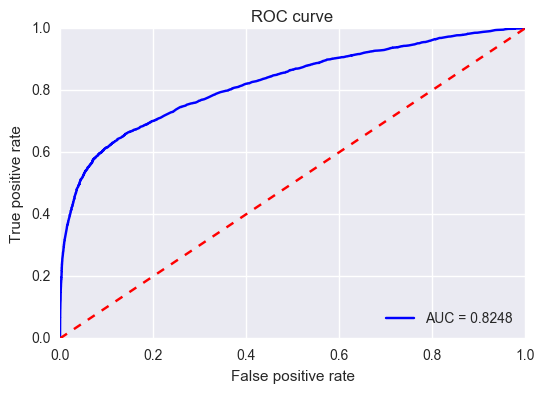

In [127]:
y_train_proba = gs_gb.predict_proba(X_train_gb)[:,1]
fpr, tpr, threshold = roc_curve(y_train, y_train_proba)
train_roc = roc_auc_score(y_train, y_train_proba)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % train_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc = 'lower right')
plt.title('ROC curve')
plt.show()

In [136]:
#creating matrix of features for test set
X_test_num_sq = pf.transform(df_test_num.values)
X_test_num_sq = scaler.transform(X_test_num_sq)

X_test_cat = ohe.transform(df_test_cat.values)
X_test = np.concatenate((X_test_num_sq, X_test_cat.toarray()), axis = 1)
X_test = gb_model.transform(X_test)
print(X_test.shape)

(10297, 26)


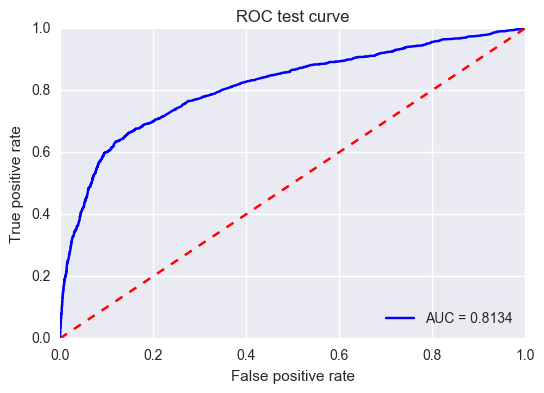

In [137]:
y_proba = gs_gb.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
test_roc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % test_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc = 'lower right')
plt.title('ROC test curve')
plt.show()

In [140]:
y_pred = gs_gb.predict(X_test)
print(test_roc, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred))

0.813386694116 0.90016509663 [[8963  174]
 [ 854  306]]


Conclusion:

* On test set we have ROC AUC score 0.8134, which is even better than in original paper (authors referred to 0.8)
* Accuracy is slightly more than 90%, good result, but that classes here are unbalanced, not extraordinary
* We have rather high precision, but rather low recall, using oversampling or undersampling method might help to increase the number of true positive, but we will increase also the number of false positive.